In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso,LinearRegression

In [3]:
train=pd.read_csv(r'D:\Downloads\jantatime\train.csv')
test=pd.read_csv(r'D:\Downloads\jantatime\test.csv')
train.tail()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
26491,34891,2017-06-23 19:00:00,-0.7,-15.0,1009.0,51.685,A,225.0
26492,34892,2017-06-23 20:00:00,-2.9,-11.4,1005.0,56.105,A,213.0
26493,34893,2017-06-23 21:00:00,-1.4,-12.9,995.0,61.275,A,213.0
26494,34894,2017-06-23 22:00:00,-2.9,-11.4,996.0,67.210,A,210.0
26495,34895,2017-06-23 23:00:00,-2.1,-11.4,1009.0,71.880,A,210.0


In [4]:
test.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A


In [5]:
train.shape

(26496, 8)

In [6]:
train.var2.value_counts()

A    25239
C     1040
B      217
Name: var2, dtype: int64

In [7]:
train.datetime=pd.to_datetime(train.datetime)

In [35]:
train1=train[['datetime','electricity_consumption']]
train1.set_index('datetime',inplace=True)

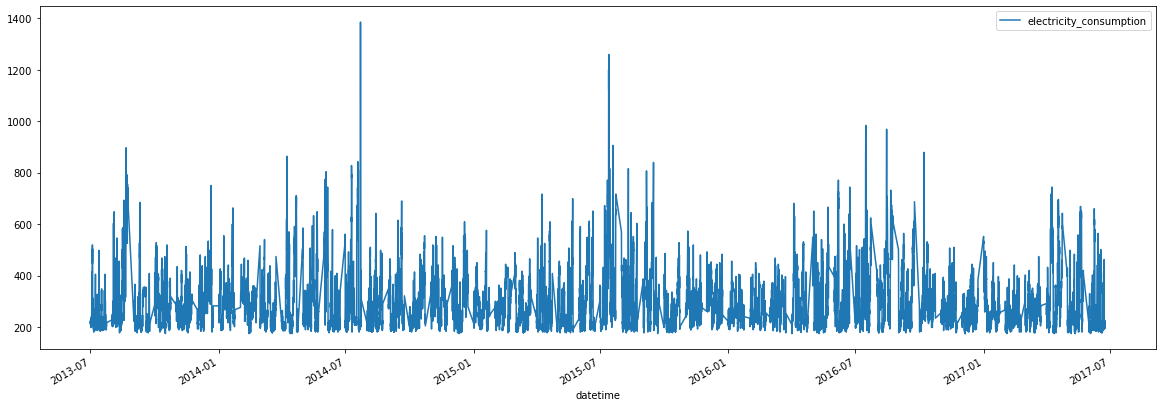

In [36]:
train1.plot(figsize=(20,7))

In [37]:
24*365*4 # should the number of rows,somewhere data is missing.

35040

C:\Users\pankaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\pankaj\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


IndexError: index 0 is out of bounds for axis 0 with size 0

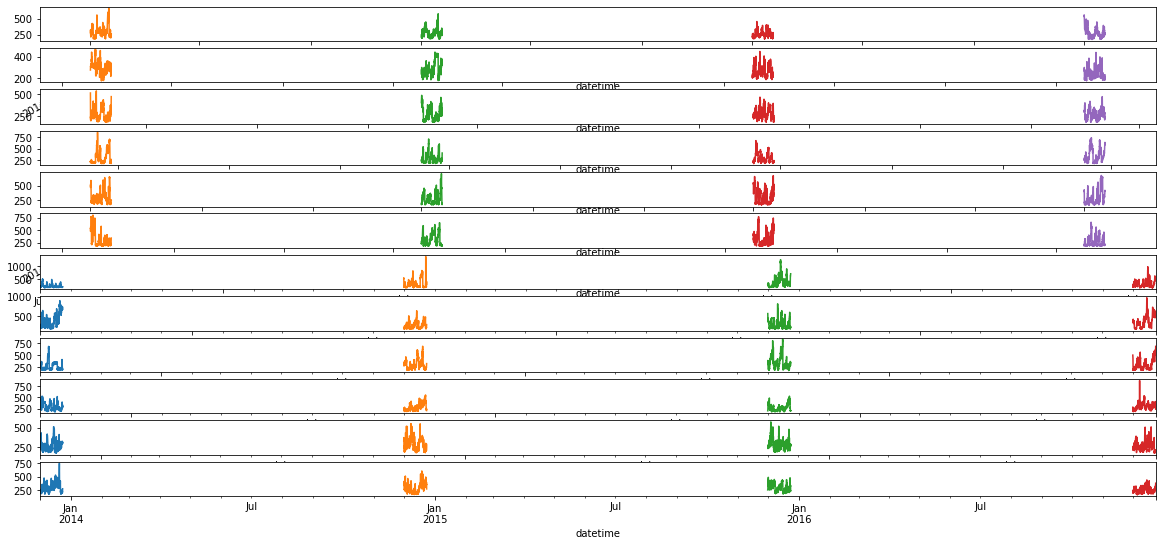

In [43]:
_,ax=plt.subplots(nrows=12,ncols=1,figsize=(20,10))
train1['year']=train1.index.year
train1['month']=train1.index.month
for year in [2013,2014,2015,2016,2017]:
    for month,space in zip(range(1,13),ax.flatten()):
        train1.loc[(train1.year==year)&(train1.month==month),'electricity_consumption'].plot(ax=space)

In [33]:
train1.index.map(str)

Index(['2013-07-01 00:00:00', '2013-07-01 01:00:00', '2013-07-01 02:00:00',
       '2013-07-01 03:00:00', '2013-07-01 04:00:00', '2013-07-01 05:00:00',
       '2013-07-01 06:00:00', '2013-07-01 07:00:00', '2013-07-01 08:00:00',
       '2013-07-01 09:00:00',
       ...
       '2017-06-23 14:00:00', '2017-06-23 15:00:00', '2017-06-23 16:00:00',
       '2017-06-23 17:00:00', '2017-06-23 18:00:00', '2017-06-23 19:00:00',
       '2017-06-23 20:00:00', '2017-06-23 21:00:00', '2017-06-23 22:00:00',
       '2017-06-23 23:00:00'],
      dtype='object', name='datetime', length=26496)

In [31]:
train['dayofyear']=train.datetime.dt.dayofyear

In [32]:
train['day']=train.datetime.dt.day
train['month']=train.datetime.dt.month
train['year']=train.datetime.dt.year
train['hour']=train.datetime.dt.hour

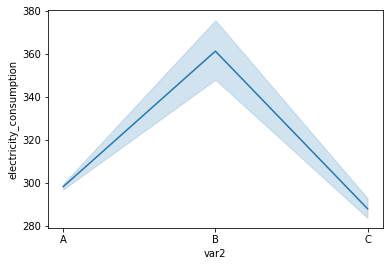

In [33]:
sns.lineplot(x='var2',y='electricity_consumption',data=train)

[Text(0.5, 0, 'range(0, 365)')]

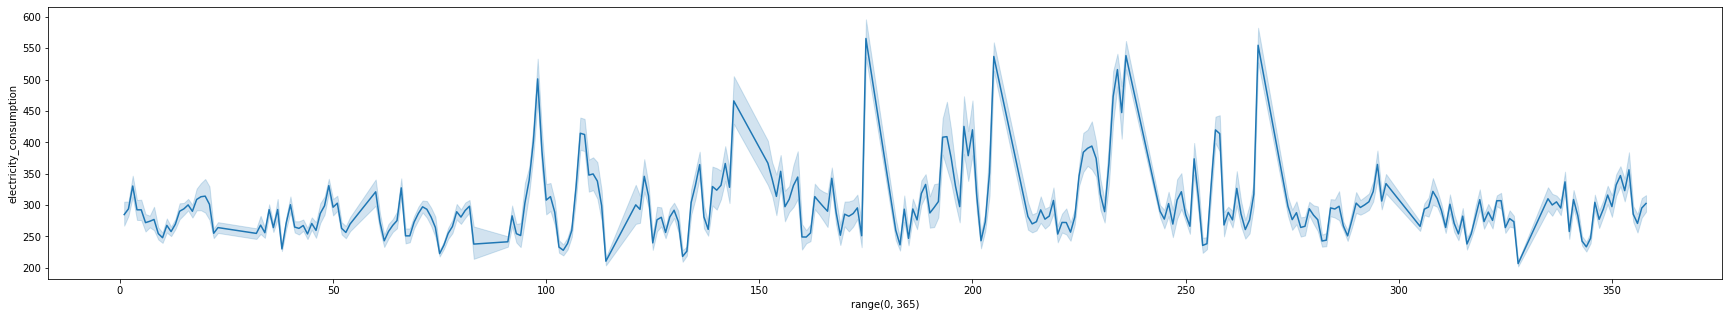

In [12]:
plt.figure(figsize=(30,5))
g=sns.lineplot(x='dayofyear',y='electricity_consumption',data=train)
g.set(xlabel=range(365))

In [34]:
train['dayofyear_hour']=train.dayofyear.map(str)+'_'+train.hour.map(str)
train=train.sort_values(by=['year','dayofyear','hour'])

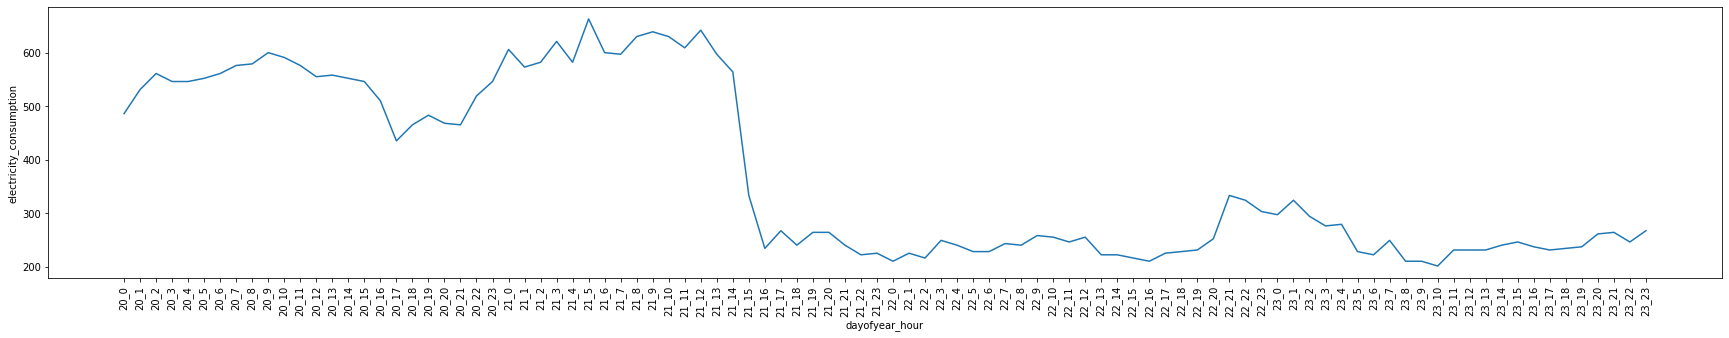

In [40]:
train10=train.loc[(train.dayofyear<=24)&(train.dayofyear>=20)]
plt.figure(figsize=(30,5))
plt.xticks(rotation=90)
sns.lineplot(x='dayofyear_hour',y='electricity_consumption',data=train10.loc[train10.year==2014],sort=False)

In [910]:
train.var2=train.var2.replace({'A':20,'B':50,'C':10})
train['dayofweek']=train.datetime.dt.dayofweek

train['ex1']=train.month.apply(lambda x: 1 if x in [8,9] else 0)
train['ex2']=train.year.apply( lambda x: 1 if x in [2013,2017] else 0)
train['ex3']=train.year.apply( lambda x: 1 if x in [2015,2017] else 0)
train['seoson1']=train.ex1*train.ex2
train['seoson2']=train.ex1*train.ex3

In [912]:
train['seoson']=train.month.apply(lambda x: 2 if x>=4 and x<=8 else 1)

In [913]:
train['nature']=train.hour.apply(lambda x: 2 if x>=8 and x<=18 else 1)

In [914]:
train['year_month']=(train.year.map(str)+train.month.map(str)).map(int)

In [915]:
train.tail()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption,day,month,year,hour,dayofweek,dayofyear,seoson,nature,year_month
26491,34891,2017-06-23 19:00:00,-0.7,-15.0,1009.0,51.685,20,225.0,23,6,2017,19,4,174,2,1,20176
26492,34892,2017-06-23 20:00:00,-2.9,-11.4,1005.0,56.105,20,213.0,23,6,2017,20,4,174,2,1,20176
26493,34893,2017-06-23 21:00:00,-1.4,-12.9,995.0,61.275,20,213.0,23,6,2017,21,4,174,2,1,20176
26494,34894,2017-06-23 22:00:00,-2.9,-11.4,996.0,67.210,20,210.0,23,6,2017,22,4,174,2,1,20176
26495,34895,2017-06-23 23:00:00,-2.1,-11.4,1009.0,71.880,20,210.0,23,6,2017,23,4,174,2,1,20176


In [916]:
train['month_hour']=train.month.map(str)+'_'+train.hour.map(str)
train=train.sort_values(by=['year','month','hour'])

plt.figure(figsize=(30,5))
plt.xticks(rotation=90)
sns.lineplot(x='month_hour',y='electricity_consumption',data=train,hue='year',sort=False,ci=False)
# year will play important role

In [917]:
label=train.copy().pop('electricity_consumption')
feature=train.copy().drop(['electricity_consumption','ID','datetime','month_hour'],axis=1)

sns.regplot(x='hour',y='temperature',data=feature)

In [918]:
feature.tail()

,temperature,var1,pressure,windspeed,var2,day,month,year,hour,dayofweek,dayofyear,seoson,nature,year_month
26399,-5.0,-17.1,1012.0,312.760,20,19,6,2017,23,0,170,2,1,20176
26423,-7.1,-12.9,990.0,2.140,20,20,6,2017,23,1,171,2,1,20176
26447,-5.7,-9.3,994.0,3.920,20,21,6,2017,23,2,172,2,1,20176
26471,-5.7,-15.0,1001.0,3.665,20,22,6,2017,23,3,173,2,1,20176
26495,-2.1,-11.4,1009.0,71.880,20,23,6,2017,23,4,174,2,1,20176


In [919]:
feature['hourre']=np.abs(feature.hour-12)

# Validation

In [931]:
score=[]
for trainind,testind in StratifiedKFold(n_splits=5,shuffle=True,random_state=88).split(feature,label):
    X_train,y_train=feature.loc[trainind],label.loc[trainind]
    X_test,y_test=feature.loc[testind],label.loc[testind]
    lgb=LinearRegression().fit(X_train,y_train)
    y_pred=lgb.predict(X_test)
    score.append(mean_squared_error(y_test,y_pred)**.5)
np.array(score).mean()    

C:\Users\pankaj\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


92.10646080673096

In [932]:
score

[91.08307837466913,
 90.99203653547244,
 90.89197434444286,
 91.10185960520931,
 96.4633551738611]

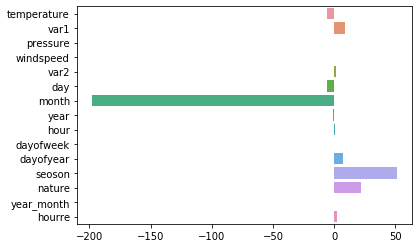

In [933]:
sns.barplot(x=lgb.coef_,y=feature.columns)

In [660]:
from sklearn.feature_selection import RFE
rfe=RFE(estimator=lgb,n_features_to_select=11,step=2).fit(feature,label)

In [661]:
selected_col=feature.columns[rfe.support_]

# test preprocessing

In [934]:
test=pd.read_csv(r'D:\Downloads\jantatime\test.csv')
id=test.ID
test['datetime']=pd.to_datetime(test.datetime)
test['day']=test.datetime.dt.day
test['month']=test.datetime.dt.month
test['year']=test.datetime.dt.year
test['hour']=test.datetime.dt.hour
test['hourre']=np.abs(test.hour-12)
test['dayofweek']=test.datetime.dt.dayofweek
test.var2=test.var2.replace({'A':20,'B':50,'C':10})
test['dayofyear']=test.datetime.dt.dayofyear
'''test['ex1']=test.month.apply(lambda x: 1 if x in [8,9] else 0)
test['ex2']=test.year.apply( lambda x: 1 if x in [2013,2017] else 0)
test['ex3']=test.year.apply( lambda x: 1 if x in [2015,2017] else 0)
test['seoson1']=test.ex1*test.ex2
test['seoson2']=test.ex1*test.ex3'''
test['nature']=test.hour.apply(lambda x: 2 if x>=8 and x<=18 else 1)
test['year_month']=(test.year.map(str)+test.month.map(str)).map(int)
test['seoson']=test.month.apply(lambda x: 2 if x>=4 and x<=8 else 1)
test.drop(['ID','datetime'],axis=1,inplace=True)

In [935]:
feature.shape,test.shape

((26496, 15), (8568, 15))

# Final model

In [936]:
lgb.fit(feature,label)
y_pred=lgb.predict(test[feature.columns])

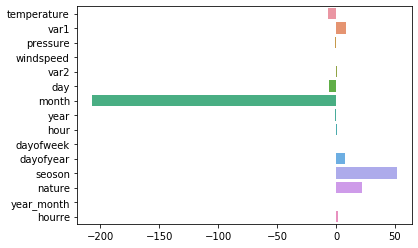

In [937]:
sns.barplot(x=lgb.coef_,y=feature.columns)

In [938]:
test['consumption']=y_pred
submission=pd.DataFrame({'ID':id,'electricity_consumption':y_pred})
submission.to_csv(r'C:\Users\pankaj\Desktop\jantatime.csv',index=False)

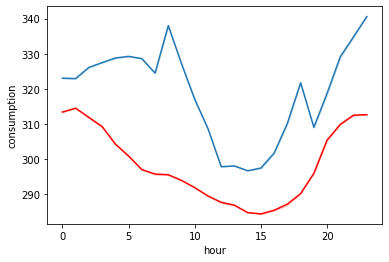

In [939]:
sns.lineplot(x='hour',y='electricity_consumption',data=train,ci=False,color='r')
sns.lineplot(x='hour',y='consumption',data=test,ci=False)

In [901]:
test.hour+=12

In [759]:
test.loc[test.month>=7,'consumption']=test.loc[test.month>=7,'consumption']-20

In [760]:
test.loc[(test.month<7) &(test.month!=1),'consumption']=test.loc[(test.month<7) &(test.month!=1),'consumption']+10

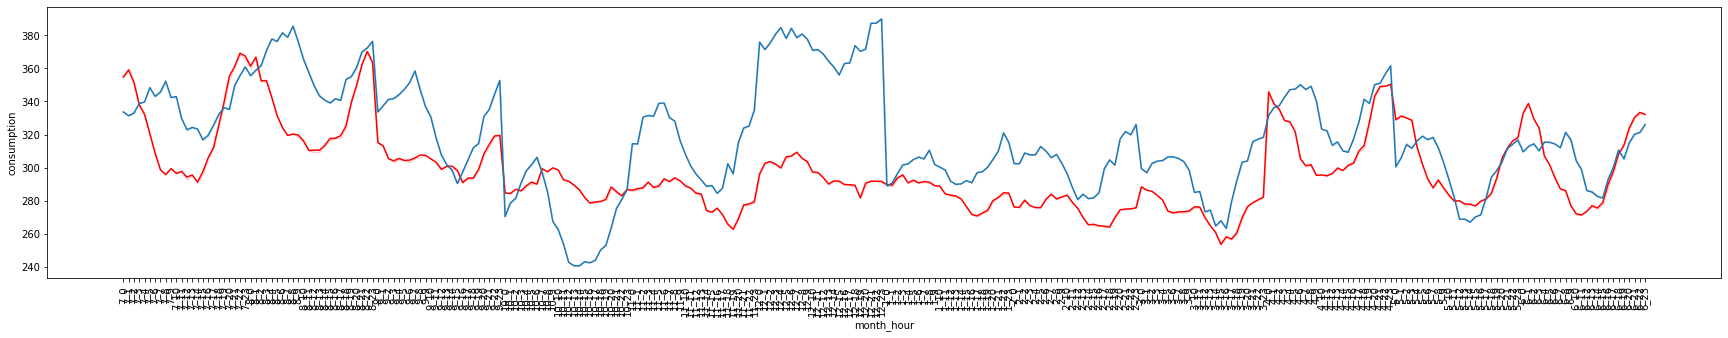

In [929]:
test['month_hour']=test.month.map(str)+'_'+test.hour.map(str)
test=test.sort_values(by=['year','month','hour'])
plt.figure(figsize=(30,5))
plt.xticks(rotation=90)
sns.lineplot(x='month_hour',y='electricity_consumption',data=train,sort=False,ci=False,color='r')
sns.lineplot(x='month_hour',y='consumption',data=test,sort=False,ci=False)                                                                     

In [763]:
test=test.sort_index()

In [764]:
submission=pd.DataFrame({'ID':id,'electricity_consumption':test.consumption.values})
submission.to_csv(r'C:\Users\pankaj\Desktop\jantatime.csv',index=False)